In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from glob import glob

import numpy as np

from tensorflow                   import Session
from tensorflow.contrib.framework import list_variables, load_variable

from keras                 import backend as K
from keras.layers          import Activation, BatchNormalization, Bidirectional, concatenate, \
                                  Conv2D, Dense, Input, LSTM, MaxPool2D, Reshape
from keras.models          import load_model, Model

from librosa               import midi_to_hz
from sklearn.metrics       import auc, roc_curve
from sklearn.preprocessing import binarize

from magenta.music.sequences_lib                           import pianoroll_to_note_sequence
from magenta.models.onsets_frames_transcription.infer_util import sequence_to_valued_intervals
from mir_eval.transcription                                import precision_recall_f1_overlap as Overlap
from mir_eval.transcription_velocity                       import precision_recall_f1_overlap as OverlapVolumes

Using TensorFlow backend.


In [2]:
dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 'Maestro/5-20 seconds', -87, -86, -31, -30, 40, 41

melsVal = np.load(dataFolder + '/Mels validation.npy')
print(len(melsVal), 'validation samples,', end='\t')
melsValMin, melsValMean, melsValMax = melsVal.min(), melsVal.mean(), melsVal.max()
assert melsMinMin < melsValMin < melsMinMax and melsMeanMin < melsValMean < melsMeanMax \
    and melsMaxMin < melsValMax < melsMaxMax, 'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin, melsValMean, melsValMax))

onVal, offVal, actVal, volsVal = map(np.load, ['{}/{} validation.npy'.format(
    dataFolder, name) for name in ['Onsets', 'Offsets', 'Actives', 'Volumes']])
volsValMin, volsValMean, volsValMax = volsVal.min(), volsVal.mean(), volsVal.max()
assert volsValMin == 0 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin, volsValMean, volsValMax))

3088 validation samples,	Mels decibels in range [-87 ... -31 ... 40]
Midi normalized volumes in range [0.0 ... 0.0033 ... 0.99]


Instead of training my own model, I just copy the weights from the Google's pre-trained tensorflow checkpoint:
https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip
(or look for the link here: https://github.com/tensorflow/magenta/tree/master/magenta/models/onsets_frames_transcription)

In [3]:
cptDir, lstmWidth, inputs = 'Magenta checkpoint', 256, Input(shape=(melsVal.shape[1], melsVal.shape[2]))

ConvBnRelu = lambda n: lambda x: Activation('relu')(BatchNormalization(scale=False)(
    Conv2D(n, 3, padding='same', use_bias=False)(x)))
outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
    ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

model = Model(inputs, Dense(88, activation='sigmoid')(Bidirectional(LSTM(lstmWidth,
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell_impl.py#L782
    # Sigmoid activation for hidden units, also unroll must be True, otherwise weights will be different
    # Cannot use stateful mode because backward LSTM would require reversed batch:
    recurrent_activation='sigmoid', implementation=2, return_sequences=True, unroll=True))(Dense(768, activation='relu')(
    Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))))

for i in [2, 3, 5, 6, 9, 10, 14, 15, 16]: print(*model.layers[i].weights, sep='\n', end='\n\n')
with Session() as sess: print(*['{}\t{}'.format(name, shape) for name, shape in list_variables(cptDir)], sep='\n')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 48) dtype=float32_ref>

<tf.Variable 'batch_normalization_1/beta:0' shape=(48,) dtype=float32_ref>
<tf.Variable 'batch_normalization_1/moving_mean:0' shape=(48,) dtype=float32_ref>
<tf.Variable 'batch_normalization_1/moving_variance:0' shape=(48,) dtype=float32_ref>

<tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 48, 48) dtype=float32_ref>

<tf.Variable 'batch_normalization_2/beta:0' shape=(48,) dtype=float32_ref>
<tf.Variable 'batch_normalization_2/moving_mean:0' shape=(48,) dtype=float32_ref>
<tf.Variable 'batch_normalization_2/moving_variance:0' shape=(48,) dtype=float32_ref>

<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 48, 96) dtype=float32_ref>

<tf.Variable 'batch_normalization_3/beta:0' shape=(96,) dtype=float32_ref>
<tf.Variable 'batch_normalization_3/moving_mean:0' shape=(96,) dtype=float32_ref>
<tf.Variable 'batch_normalization_3/moving_variance:0' shape=(

In [4]:
def MagentaToKeras(modelName, xVal, yVal):
    numLayers, varName, varProbName = 16, modelName.lower(), None
    
    for i, j in zip(range(3), [2, 5, 9]):
        model.layers[j    ].set_weights([load_variable(cptDir, '{}/conv{}/weights'     .format(varName, i))])
        model.layers[j + 1].set_weights([load_variable(cptDir, '{}/conv{}/BatchNorm/{}'.format(varName, i, name))
                                         for name in ['beta', 'moving_mean', 'moving_variance']])
    model.layers[14].set_weights([load_variable(cptDir, '{}/fc_end/{}'.format(varName, name))
                                  for name in ['weights', 'biases']])
    
    if modelName in ['Onsets', 'Offsets']: varProbName = varName[:-1] + '_probs'
    elif modelName == 'Velocity': numLayers, varProbName = 15, 'onset_velocities'
    else:
        assert modelName == 'Frame', 'Illegal model name'
        numLayers, varProbName = 20, 'frame_probs'
        model.layers[16].set_weights([load_variable(cptDir, 'frame/activation_probs/{}'.format(name))
                                      for name in ['weights', 'biases']])

    if modelName != 'Velocity':
        fW, fB, bW, bB = [load_variable(cptDir, '{}/cudnn_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/'
            '{}/cudnn_compatible_lstm_cell/{}'.format(varName, fb, kb)) for fb in ['fw', 'bw'] for kb in ['kernel', 'bias']]
        # https://stackoverflow.com/questions/48212694/in-what-order-are-weights-saved-in-a-lstm-kernel-in-tensorflow
        # Tensorflow order is I-C-F-O:
        (fWi, fWc, fWf, fWo), (bWi, bWc, bWf, bWo) = map(lambda arr: np.split(arr, 4, 1), [fW, bW])
        (fBi, fBc, fBf, fBo), (bBi, bBc, bBf, bBo) = map(lambda arr: np.split(arr, 4),    [fB, bB])
        # https://stackoverflow.com/questions/47661105/order-of-lstm-weights-in-keras
        # Keras order is I-F-C-O:
        fWk, bWk, fBk, bBk = map(np.hstack, [[fWi, fWf, fWc, fWo], [bWi, bWf, bWc, bWo],
                                             [fBi, fBf, fBc, fBo], [bBi, bBf, bBc, bBo]])
        # https://stats.stackexchange.com/questions/280995/accessing-lstm-weights-tensors-in-tensorflow
        # Input units first, then hidden (recurrent) nodes:
        model.layers[numLayers - 1].set_weights([fWk[:-lstmWidth], fWk[-lstmWidth:], fBk,
                                                 bWk[:-lstmWidth], bWk[-lstmWidth:], bBk])

    model.layers[numLayers].set_weights([load_variable(cptDir, '{}/{}/{}'.format(
        varName, varProbName, name)) for name in ['weights', 'biases']])
    model.save('Magenta {} {:.2f}.hdf5'.format(modelName, model.evaluate(
        xVal, yVal, 32, 1)[1] * 100), include_optimizer=False)

def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1 if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Onsets', melsVal, onVal)
onProb = model.predict(melsVal, 16, 1)

MagentaToKeras('Offsets', melsVal, offVal)
offProb = model.predict(melsVal, 16, 1)

def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

model = Model(model.input, Dense(volsVal.shape[2], activation='sigmoid')(model.layers[-3].output))
model.compile('Adam', 'categorical_crossentropy', [VolAcc])
MagentaToKeras('Velocity', melsVal, volsVal)
volsProb = model.predict(melsVal, 32, 1)

onsetsIn, offsetsIn = Input(shape=(onVal.shape[1], onVal.shape[2])), Input(shape=(offVal.shape[1], offVal.shape[2]))
model = Model([onsetsIn, model.input, offsetsIn], Dense(actVal.shape[2], activation='sigmoid')(
    Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
                       unroll=True))(concatenate([onsetsIn, model.output, offsetsIn]))))
model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal)
actProb = model.predict([onProb, melsVal, offProb], 16, 1)

3088/3088 [==============================] - 96s 31ms/step


# Testing.

In [4]:
fps = 16_000 / 512
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model('Magenta {}.hdf5'.format(
    name), compile=False), ['Onsets 67.74', 'Offsets 44.52', 'Frame 76.97', 'Velocity 93.42'])

for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        'Maestro/1-5 seconds/test/*{}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(' '.join(mels.split()[:-1]))
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    assert abs(numOnsetsTrue - numOnsetsPred) < .1

Instructions for updating:
Colocations handled automatically by placer.
Maestro/1-5 seconds/test\2004
	1 of 9
12/12 [==============================] - 15s 1s/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 9
17/17 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 9
11/11 [==============================] - 0s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 9
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 9
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 9
26/26 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 9
15/15 [==============================] - 0s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 9
66/66 [==============================] - 2s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 9
56/56 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 81.15%
Recall    (sensitivity) = 90.09%
F1-score                = 84.88%

Frames: 
Precision (specificity) = 65.05%
Recall    (sensitivity) = 71.51%
F1-score                = 67.78%

Volumes:
Precision (specificity) = 62.40%
Recall    (sensitivity) = 68.59%
F1-score                = 65.01%

Actual and predicted average number of onsets: 1.71 1.67
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2006
	1 of 11
37/37 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 11
35/35 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 11
64/64 [==============================] - 2s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 11
31/31 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 11
7/7 [==============================] - 0s 39ms/step
	6 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


19/19 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 11
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 11
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 11
26/26 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 11
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 11
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 80.92%
Recall    (sensitivity) = 89.34%
F1-score                = 84.76%

Frames: 
Precision (specificity) = 63.30%
Recall    (sensitivity) = 69.87%
F1-score                = 66.30%

Volumes:
Precision (specificity) = 60.67%
Recall    (sensitivity) = 66.95%
F1-score                = 63.53%

Actual and predicted average number of onsets: 1.75 1.70
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2008
	1 of 22
4/4 [==============================] - 0s 51ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 22
12/12 [==============================] - 0s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 22
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 22
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 22
27/27 [==============================] - 1s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 22
21/21 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 22
14/14 [==============================] - 0s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 22
31/31 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 22
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 22
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 22
18/18 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 22
4/4 [==============================] - 0s 52ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 22
18/18 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 22
10/10 [==============================] - 0s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 22
14/14 [==============================] - 0s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 22
9/9 [==============================] - 0s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	17 of 22
21/21 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	18 of 22
6/6 [==============================] - 0s 42ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	19 of 22
32/32 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	20 of 22
15/15 [==============================] - 0s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	21 of 22
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	22 of 22
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 80.40%
Recall    (sensitivity) = 88.71%
F1-score                = 83.70%

Frames: 
Precision (specificity) = 65.51%
Recall    (sensitivity) = 71.74%
F1-score                = 68.01%

Volumes:
Precision (specificity) = 62.97%
Recall    (sensitivity) = 68.95%
F1-score                = 65.37%

Actual and predicted average number of onsets: 1.77 1.71
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2009
	1 of 17
5/5 [==============================] - 0s 47ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 17
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 17
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 17
21/21 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 17
40/40 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 17
81/81 [==============================] - 2s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 17
72/72 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 17
17/17 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 17
12/12 [==============================] - 0s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 17
47/47 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 17
65/65 [==============================] - 2s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 17
9/9 [==============================] - 0s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 17
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 17
46/46 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 17
73/73 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 17
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	17 of 17
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 84.51%
Recall    (sensitivity) = 92.21%
F1-score                = 88.00%

Frames: 
Precision (specificity) = 67.02%
Recall    (sensitivity) = 72.83%
F1-score                = 69.65%

Volumes:
Precision (specificity) = 63.62%
Recall    (sensitivity) = 69.17%
F1-score                = 66.13%

Actual and predicted average number of onsets: 1.60 1.58
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2011
	1 of 16
30/30 [==============================] - 1s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 16
10/10 [==============================] - 0s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 16
19/19 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 16
19/19 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 16
18/18 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 16
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 16
9/9 [==============================] - 0s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 16
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 16
15/15 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 16
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 16
17/17 [==============================] - 1s 51ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 16
13/13 [==============================] - 0s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 16
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 16
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 16
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 16
29/29 [==============================] - 1s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 85.86%
Recall    (sensitivity) = 91.92%
F1-score                = 88.67%

Frames: 
Precision (specificity) = 70.27%
Recall    (sensitivity) = 75.14%
F1-score                = 72.53%

Volumes:
Precision (specificity) = 67.46%
Recall    (sensitivity) = 72.16%
F1-score                = 69.64%

Actual and predicted average number of onsets: 1.84 1.79
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2013
	1 of 10
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 10
15/15 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10
26/26 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 10
21/21 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10
57/57 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10
19/19 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10
12/12 [==============================] - 0s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10
20/20 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10
23/23 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 82.04%
Recall    (sensitivity) = 88.30%
F1-score                = 84.99%

Frames: 
Precision (specificity) = 67.18%
Recall    (sensitivity) = 72.30%
F1-score                = 69.60%

Volumes:
Precision (specificity) = 63.77%
Recall    (sensitivity) = 68.66%
F1-score                = 66.08%

Actual and predicted average number of onsets: 2.03 1.96
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2014
	1 of 16
22/22 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 16
17/17 [==============================] - 1s 35ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 16
32/32 [==============================] - 1s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 16
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 16
61/61 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 16
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 16
39/39 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 16
57/57 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 16
33/33 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 16
74/74 [==============================] - 2s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 16
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 16
9/9 [==============================] - 0s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 16
27/27 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 16
80/80 [==============================] - 2s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 16
82/82 [==============================] - 2s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 16
36/36 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 89.96%
Recall    (sensitivity) = 92.88%
F1-score                = 91.34%

Frames: 
Precision (specificity) = 70.75%
Recall    (sensitivity) = 73.00%
F1-score                = 71.81%

Volumes:
Precision (specificity) = 68.30%
Recall    (sensitivity) = 70.46%
F1-score                = 69.32%

Actual and predicted average number of onsets: 1.63 1.61
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2015
	1 of 10
15/15 [==============================] - 0s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10
25/25 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 10
6/6 [==============================] - 0s 42ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10
7/7 [==============================] - 0s 39ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 10
6/6 [==============================] - 0s 42ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10
18/18 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10
37/37 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10
19/19 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10
15/15 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 81.63%
Recall    (sensitivity) = 92.52%
F1-score                = 86.48%

Frames: 
Precision (specificity) = 70.96%
Recall    (sensitivity) = 80.17%
F1-score                = 75.06%

Volumes:
Precision (specificity) = 66.75%
Recall    (sensitivity) = 75.42%
F1-score                = 70.61%

Actual and predicted average number of onsets: 1.71 1.68
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2017
	1 of 14
23/23 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 14
24/24 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 14
11/11 [==============================] - 0s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 14
7/7 [==============================] - 0s 38ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 14
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 14
34/34 [==============================] - 1s 30ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 14
18/18 [==============================] - 1s 34ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 14
16/16 [==============================] - 0s 27ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 14
22/22 [==============================] - 1s 32ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 14
18/18 [==============================] - 1s 33ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 14
46/46 [==============================] - 1s 28ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 14
28/28 [==============================] - 1s 29ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 14
34/34 [==============================] - 1s 31ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 14
61/61 [==============================] - 2s 28ms/step

Onsets: 
Precision (specificity) = 87.06%
Recall    (sensitivity) = 93.44%
F1-score                = 90.05%

Frames: 
Precision (specificity) = 74.81%
Recall    (sensitivity) = 80.12%
F1-score                = 77.30%

Volumes:
Precision (specificity) = 71.65%
Recall    (sensitivity) = 76.72%
F1-score                = 74.03%

Actual and predicted average number of onsets: 1.72 1.67
Predicts less notes than actual (specific classifier)



C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


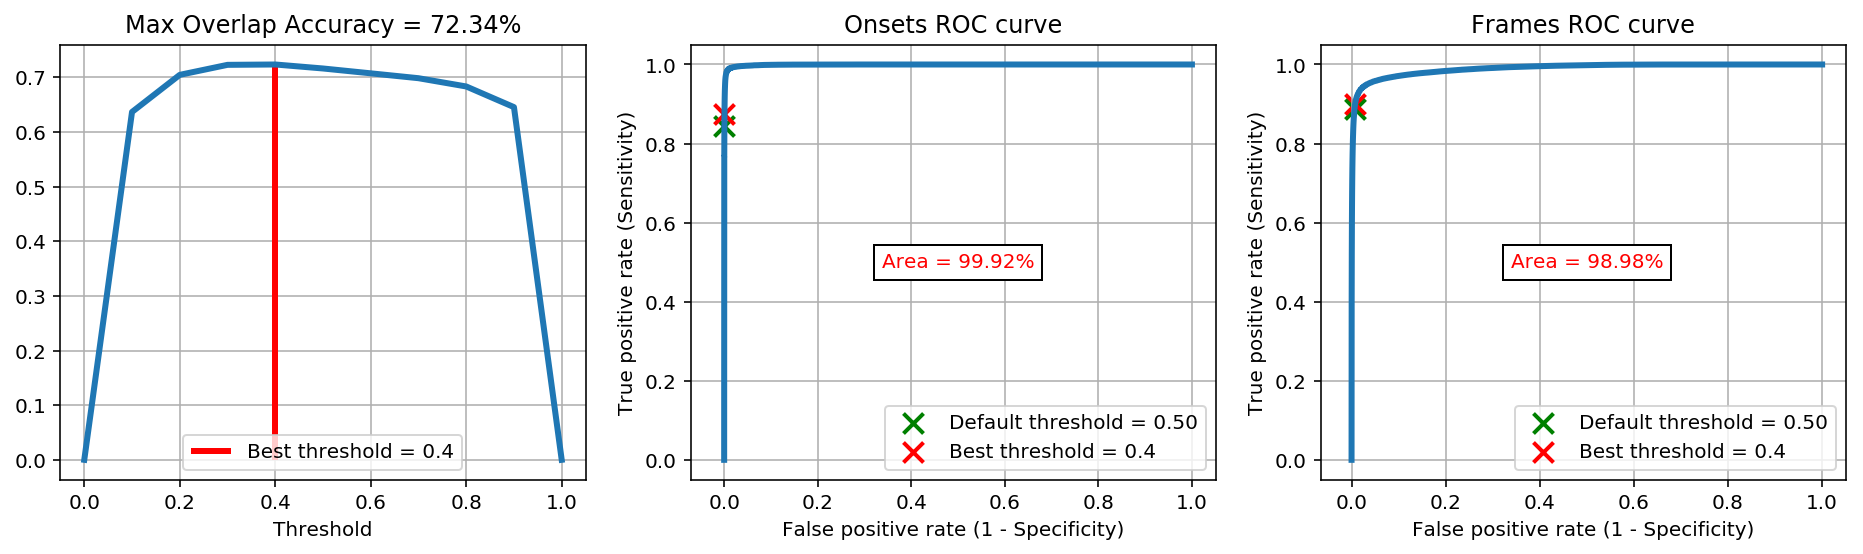

In [9]:
mels2014, onTrue2014, offTrue2014, actTrue2014, volTrue2014 = map(lambda name: np.vstack(np.load(
#    '{}/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(dataFolder, name),
    'Maestro/1-5 seconds/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2014 = np.pad(mels2014, [(0, -len(mels2014) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2014, offProb2014, volProb2014 = map(lambda mod: mod.predict(mels2014, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2014 = activesModel.predict([onProb2014, mels2014, offProb2014], 16, 1)
onProb2014, offProb2014, actProb2014, volProb2014 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2014)], [onProb2014, offProb2014, actProb2014, volProb2014])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2014, fps, 0, onset_predictions=onTrue2014, offset_predictions=offTrue2014,
            velocity_values=volTrue2014), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2014), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2014, offProb2014, actProb2014])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2014,  onProb2014, 'Onsets')
PlotROC(3, actTrue2014, actProb2014, 'Frames')

C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


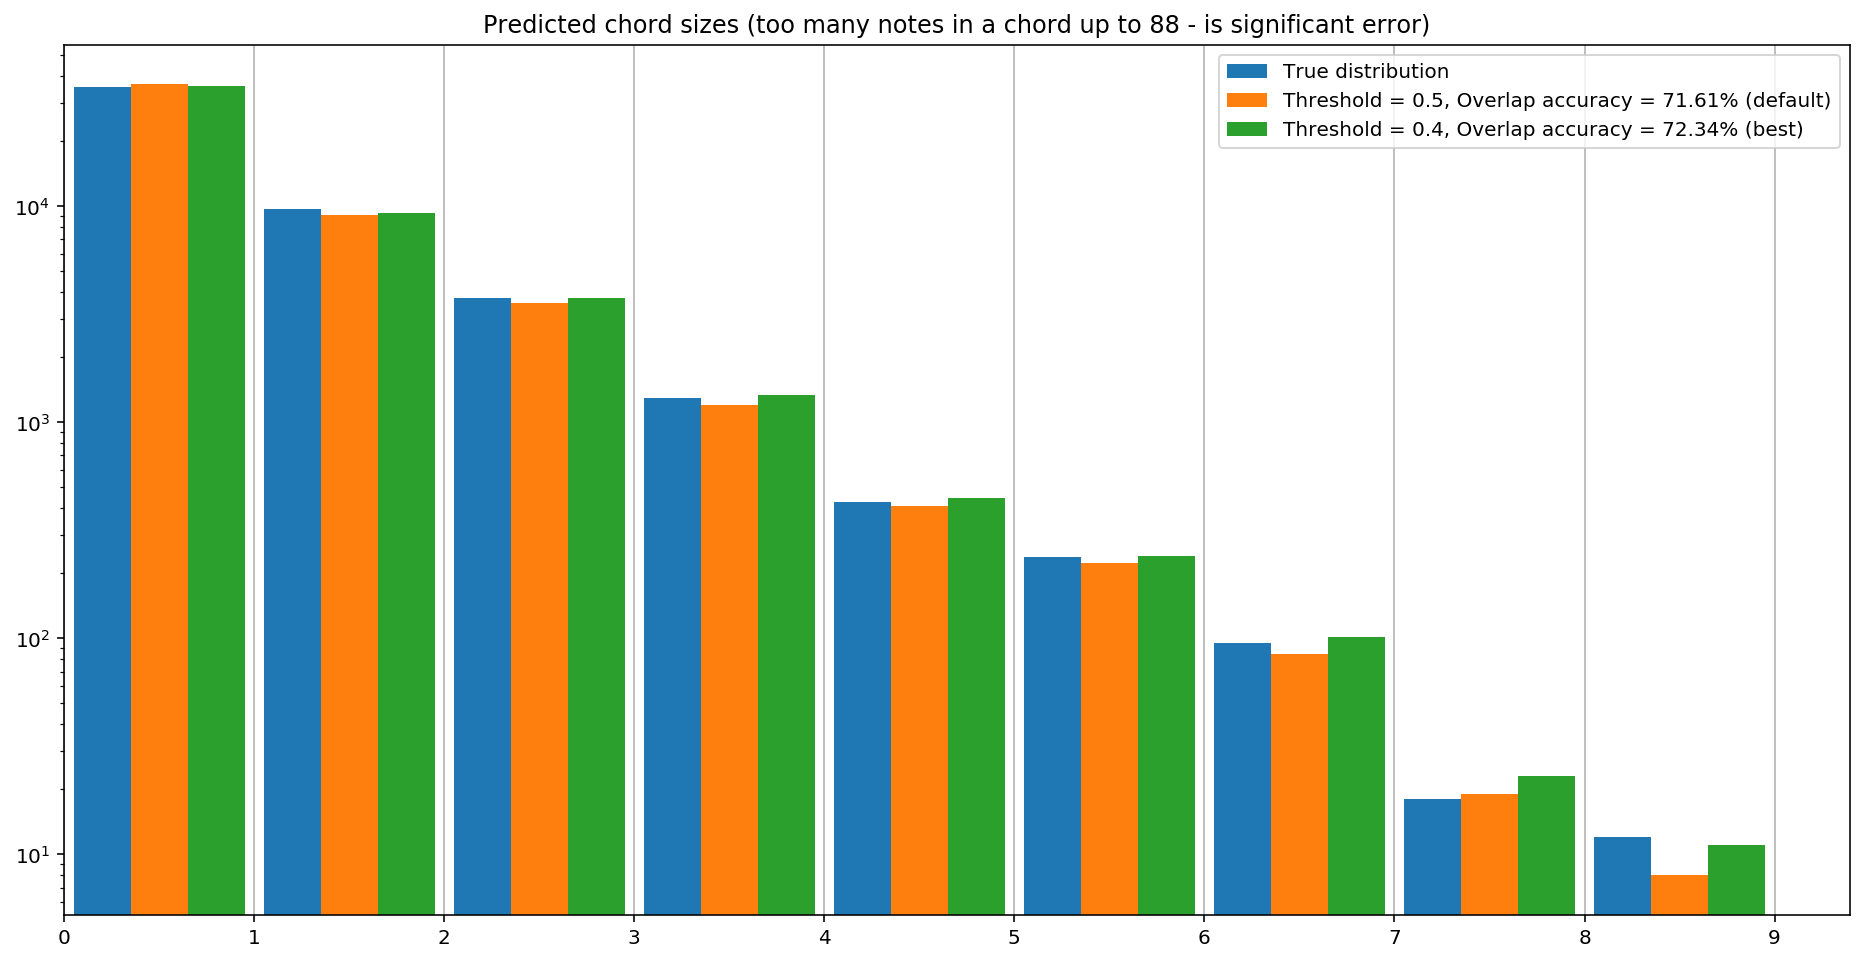

In [10]:
yPresize, yDefault = map(lambda t: binarize(onProb2014, t).astype(int), [thBest, .5])
counts = [onTrue2014.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2014, .5),     binarize(actProb2014, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2014, thBest), binarize(actProb2014, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# Keras model HDF5-file to JSON conversion<br>(without optimizer, for using just forward-pass predictions in C++):
https://github.com/Dobiasd/frugally-deep/tree/master/keras_export

In [2]:
%run convert_model.py   "Magenta Onsets 67.74.hdf5"  "Magenta Onsets.json"
print()
%run convert_model.py  "Magenta Offsets 44.52.hdf5" "Magenta Offsets.json"
print()
%run convert_model.py    "Magenta Frame 76.97.hdf5"  "Magenta Frames.json"
print()
%run convert_model.py "Magenta Velocity 93.42.hdf5" "Magenta Volumes.json"

loading Magenta Onsets 67.74.hdf5
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Evgeniy\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Forward pass took 19.303515 s.
Forward pass took 0.179831 s.
Forward pass took 0.179759 s.
Starting performance measurements.
Forward pass took 0.178003 s.
Forward pass took 0.176777 s.
Forward pass took 0.176141 s.
Forward pass took 0.175734 s.
Forward pass took 0.175005 s.
Forward pass took 0.176332 s on average.
Converting model architecture.
Determining Keras behaviour.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing Magenta Onsets.json
loading Magenta Offsets 44.52.hdf5
Forward pass took 18.219389 s.
Forward pass took 0.182343 s.
Forward pass took 0.179618 s.
Starting performance measurements.
Forward pass took 0.175767 s.
Forward pass took 0.181889 s.
Forward pass took 0.196294 s.
Forward pass took 0.182893 s.
Forward pass took 0.177664 s.
Forward pass took 0.1829014 s on average.
Converting model architecture.
Determining Keras behaviour.
Converting model weights.
Done converting model weights.
Calculating model